In [63]:
#importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from torchvision import datasets,transforms,models
from torch import nn,optim
import torch.nn.functional as F
from torch.utils.data import *

import time
import json
import copy
import os

from PIL import Image
from collections import OrderedDict

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        #transforms.RandomResizedCrop(299),  #size for inception architecture
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        #transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
    'test': transforms.Compose([
        transforms.Resize(256),                                  
        transforms.CenterCrop(224),
        #transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]),
}


CUDA is available!  Training on GPU ...


In [82]:
train_dir = 'D:/Ivan/Test_data/Stanford_AI_cars_modified/train'

#https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder
batch_size=5
dataset = datasets.ImageFolder(train_dir,transform=data_transforms['train'])

# splitting our data
valid_size  = int(0.1 * len(dataset))
train_size = len(dataset) - valid_size
dataset_sizes = {'train': train_size, 'valid': valid_size}

# now we get our datasets
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])

# Loading datasets into dataloader 
dataloaders = {'train': DataLoader(train_dataset, batch_size = batch_size, shuffle = True),
              'valid': DataLoader(valid_dataset, batch_size = batch_size, shuffle = False)}

print("Total Number of Samples: ",len(dataset))
print("Number of Samples in Train: ",len(train_dataset))
print("Number of Samples in Valid: ",len(valid_dataset))
print("Number of Classes: ",len(dataset.classes))

print(dataset.classes[1])


Total Number of Samples:  16288
Number of Samples in Train:  14660
Number of Samples in Valid:  1628
Number of Classes:  2
truck


 Sizes of Datasets:  1628 14660


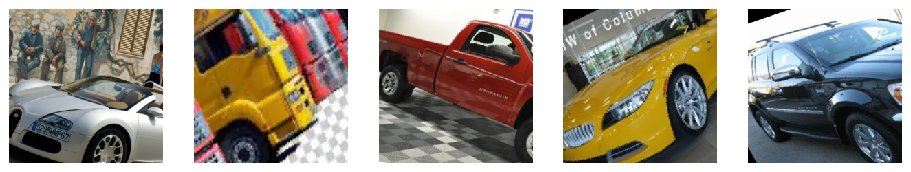

In [65]:
import matplotlib.pyplot as plt
import numpy as np

## Method to display Image for Tensor
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax


print(" Sizes of Datasets: ", len(valid_dataset), len(train_dataset))
# Displaying Training Images
images, labels = next(iter(dataloaders['train']))

fig, axes = plt.subplots(figsize=(16,5), ncols=5)
for ii in range(5):
    ax = axes[ii]
    #ax.set_title(label_map[class_names[labels[ii].item()]])
    imshow(images[ii], ax=ax, normalize=True)

In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = 'resnet' #vgg
# Densenet
if model_name == 'densenet':
    model = models.densenet161(pretrained=True)
    num_in_features = 2208
    print(model)
# VGGNet
elif model_name == 'vgg':
    model = models.vgg19(pretrained=True)
    num_in_features = 25088
    print(model.classifier)
# Resnet
elif model_name == 'resnet':
    model = models.resnet152(pretrained=True) 
    #model = models.resnet34(pretrained=True)
    num_in_features = 2048 #512 
    print(model.fc)
# Inception
elif model_name == 'inception':
  model = models.inception_v3(pretrained=True)
  model.aux_logits=False
  num_in_features = 2048
  print(model.fc)
else:
    print("Unknown model, please choose 'densenet' or 'vgg'")

Linear(in_features=2048, out_features=1000, bias=True)


In [67]:
# Freezing parameters
for param in model.parameters():
  param.require_grad = False
  
# Create Custom Classifier
def build_classifier(num_in_features, hidden_layers, num_out_features):
    classifier = nn.Sequential()
    # when we don't have any hidden layers
    if hidden_layers == None:      
        classifier.add_module('fc0', nn.Linear(num_in_features, 196))    
    #when we have hidden layers
    else:      
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        classifier.add_module('fc0', nn.Linear(num_in_features, hidden_layers[0]))
        classifier.add_module('relu0', nn.ReLU())
        classifier.add_module('drop0', nn.Dropout(.6))
        
        for i, (h1, h2) in enumerate(layer_sizes):
            classifier.add_module('fc'+str(i+1), nn.Linear(h1, h2))
            classifier.add_module('relu'+str(i+1), nn.ReLU())
            classifier.add_module('drop'+str(i+1), nn.Dropout(.5))
        classifier.add_module('output', nn.Linear(hidden_layers[-1], num_out_features))
        
    return classifier

In [68]:
#define our hidden layers
hidden_layers = None #[1050,500]
classifier = build_classifier(num_in_features, hidden_layers, 196)
print(classifier)
 # Defining model hyperparameters
if model_name == 'densenet':
    model.classifier = classifier
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adadelta(model.parameters()) # Adadelta #weight optim.Adam(model.parameters(), lr=0.001, momentum=0.9)
   # Decay Learning Rate by a factor of 0.1 every 4 epochs
    sched = optim.lr_scheduler.StepLR(optimizer, step_size=4)
elif model_name == 'vgg':
    model.classifier = classifier
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)
    sched = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
elif model_name == 'resnet':
  model.fc = classifier
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  sched = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)
elif model_name == 'inception':
    model.fc = classifier
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9)
else:
    pass

Sequential(
  (fc0): Linear(in_features=2048, out_features=196, bias=True)
)


In [69]:
# Training 
def train_model(model, criterion, optimizer, sched, num_epochs=5,device='cuda'):
    start = time.time()
    train_results = []
    valid_results = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':            
              model.train()  # Set model to training mode
            else:
              model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        #sched.step()
                        loss.backward()
                        
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if(phase == 'train'):
              train_results.append([epoch_loss,epoch_acc])
            if(phase == 'valid'):
              valid_results.append([epoch_loss,epoch_acc])
                                   
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model (Early Stopping) and Saving our model, when we get best accuracy
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())       
                model_save_name = "resnetCars.pt"
                path = F"./{model_save_name}"
                torch.save(model.state_dict(), path)        

        print()

    # Calculating time it took for model to train    
    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    #load best model weights
    model.load_state_dict(best_model_wts)
    
    return model,train_results,valid_results

In [70]:
epochs = 60
#move model to GPU
model.to(device)
model,train_results,valid_results = train_model(model, criterion, optimizer, sched, epochs)

Epoch 1/60
----------
train Loss: 0.7732 Acc: 0.5465
valid Loss: 0.7121 Acc: 0.5977

Epoch 2/60
----------
train Loss: 0.6546 Acc: 0.6272
valid Loss: 0.7011 Acc: 0.5012

Epoch 3/60
----------
train Loss: 0.6239 Acc: 0.6579
valid Loss: 0.5295 Acc: 0.7549

Epoch 4/60
----------
train Loss: 0.5452 Acc: 0.7291
valid Loss: 0.4159 Acc: 0.8188

Epoch 5/60
----------
train Loss: 0.5348 Acc: 0.7336
valid Loss: 0.4604 Acc: 0.7764

Epoch 6/60
----------
train Loss: 0.4874 Acc: 0.7632
valid Loss: 0.4797 Acc: 0.7758

Epoch 7/60
----------
train Loss: 0.4360 Acc: 0.7976
valid Loss: 0.4126 Acc: 0.8071

Epoch 8/60
----------
train Loss: 0.4047 Acc: 0.8162
valid Loss: 0.3902 Acc: 0.8219

Epoch 9/60
----------
train Loss: 0.3782 Acc: 0.8303
valid Loss: 0.3439 Acc: 0.8563

Epoch 10/60
----------
train Loss: 0.3539 Acc: 0.8426
valid Loss: 0.3570 Acc: 0.8440

Epoch 11/60
----------
train Loss: 0.3417 Acc: 0.8537
valid Loss: 0.3010 Acc: 0.8686

Epoch 12/60
----------
train Loss: 0.3232 Acc: 0.8595
valid Los

In [79]:
model.load_state_dict(torch.load('D:/Ivan/cardetection_Models/resnetCars_Mar_5_2020.pt'))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [80]:
total = 0
correct = 0
test_dir = 'D:/Ivan/Test_data/Stanford_AI_cars_modified/test'
dataset = datasets.ImageFolder(test_dir,transform=data_transforms['test'])
testloader = torch.utils.data.DataLoader(dataset, batch_size=4,
                                         shuffle=False, num_workers=2)
with torch.no_grad():
    for inputs,labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        #print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network : %d %%' % (
    100 * correct / total))

Accuracy of the network : 97 %


In [ ]:
# https://deeplizard.com/learn/video/cin4YcGBh3Q
# to calculate height of channel o=((input_size-filter+2*padding)/stride)+1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 32, 5)
        self.fc1 = nn.Linear(32 * 216 * 216, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 216 * 216)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
device = torch.device("cuda:0")
print(device)
if device:
    net.to(device)
    print("Network transfer to GPU")
print("Network transfer on GPU done")




In [43]:

for epoch in range(6):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloaders['train'], 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

RuntimeError: shape '[-1, 1492992]' is invalid for input of size 2876416

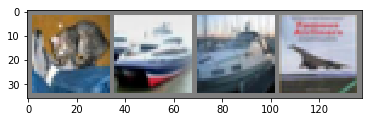

GroundTruth:    cat  ship  ship plane


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [93]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)
dataiter = iter(testloader)
images, labels = dataiter.next()


# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
net = Net()
net.load_state_dict(torch.load(PATH))

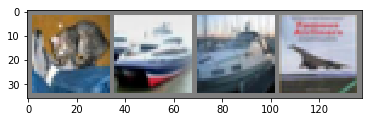

GroundTruth:    cat  ship  ship plane


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [94]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
net = Net()
net.load_state_dict(torch.load(PATH))

In [95]:
net = Net()
net.load_state_dict(torch.load(PATH))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [96]:
total = 0
correct = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 73 %


In [97]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 77 %
Accuracy of   car : 83 %
Accuracy of  bird : 66 %
Accuracy of   cat : 57 %
Accuracy of  deer : 65 %
Accuracy of   dog : 60 %
Accuracy of  frog : 83 %
Accuracy of horse : 75 %
Accuracy of  ship : 89 %
Accuracy of truck : 77 %


In [26]:
net.conv1.weight

Parameter containing:
tensor([[[[-3.2993e-02, -2.3405e-03,  2.1536e-02, -9.9217e-02,  3.8875e-02],
          [-1.4608e-01, -1.2142e-01, -1.3833e-01, -1.1703e-01, -8.1771e-02],
          [-4.3233e-02, -8.1761e-02, -9.9388e-02, -6.4674e-02,  2.0620e-02],
          [ 1.0191e-01,  8.5324e-02,  1.0056e-01,  7.8439e-02,  1.3406e-01],
          [ 1.8527e-01,  2.3297e-01,  2.0644e-01,  8.7565e-02,  2.3663e-01]],

         [[ 1.1522e-02,  6.3033e-02,  2.1163e-01, -1.0223e-03, -4.1490e-02],
          [ 1.8605e-01,  5.1929e-02, -1.4299e-01, -1.6272e-01, -1.0454e-01],
          [ 2.4002e-01,  1.9913e-01, -1.8517e-01, -1.8084e-01, -1.1473e-01],
          [ 9.6181e-02,  1.3058e-01,  7.5518e-03, -6.7408e-02, -2.2133e-01],
          [ 1.0673e-01,  1.1112e-02,  6.9191e-02, -7.7813e-02, -1.6184e-01]],

         [[ 2.8479e-01,  4.1621e-01,  2.1255e-01,  5.1796e-02, -2.4858e-01],
          [ 5.3052e-01,  4.3750e-01,  1.1120e-01, -1.1682e-01, -3.2388e-01],
          [ 5.1614e-01,  3.1956e-01,  3.1955e-02, 

In [2]:
t = torch.tensor([1,2,3])

In [3]:
t = t.cuda()
t

tensor([1, 2, 3], device='cuda:0')

In [4]:
t.device()

TypeError: 'torch.device' object is not callable

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.cuda.current_device()

0

In [7]:
torch.cuda.get_device_name()

'GeForce GTX 1070 Ti'

In [3]:
print(torch.__version__)

1.1.0


In [4]:
import torch
from torch.utils.tensorboard import SummaryWriter

In [1]:
import torch
import torchaudio

ModuleNotFoundError: No module named 'torchaudio'